**Descrição**

Este script serve como análise final da investigação de índices quantitativos do SNA para classificação e predição entre indivíduos portadores de Diabetes Mellitus e de controle.

**Importação de bibliotecas**

In [4]:
# Limpando ambiente
%reset

# Ignorando mensagens de aviso
import warnings
warnings.filterwarnings('ignore')

#Bibliotecas Relevantes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Biblioteca auxiliar para codificação das Labels
from sklearn.preprocessing import StandardScaler 

# Biblioteca para Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Modelos de Treinamento
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Suporte de métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

**Carregamento e separação de dados**

In [5]:
# Carregamento e organização de dados

## Sem outliers

dados_sem_outliers_geral_j1 = pd.read_csv(r'C:\Users\AlexA\Meu Drive\UnB - Mestrado - Regular\Projeto e Pesquisa\Repositório de Dados\Dados Pré-processados\CDED-1.0.1-final\Planilhas e Dados de Controle\ML_Dataset\Features_Without_Outliers_GERAL_Pearson_J1.csv')

dados_sem_outliers_geral_j2 = pd.read_csv(r'C:\Users\AlexA\Meu Drive\UnB - Mestrado - Regular\Projeto e Pesquisa\Repositório de Dados\Dados Pré-processados\CDED-1.0.1-final\Planilhas e Dados de Controle\ML_Dataset\Features_Without_Outliers_GERAL_Pearson_J2.csv')

## Caminho para salvamento de arquivos

caminho_salvamentos = r'C:\Users\AlexA\Meu Drive\UnB - Mestrado - Regular\Projeto e Pesquisa\Repositório de Dados\Dados Pré-processados\CDED-1.0.1-final\Planilhas e Dados de Controle\ML-1-Feature\Grupo'

## Unificando dados

dados_sem_outliers_geral = dados_sem_outliers_geral_j1.append(dados_sem_outliers_geral_j2, ignore_index=True)

## Labels

labels = dados_sem_outliers_geral[["LABEL"]]

## Métricas avaliadas

Colunas_metricas = ['Marcador', 'Algoritmo', 'Metodo', 
                    'Acuracia_Validacao', 'Precisao_Validacao', 'Sensibilidade_Validacao', 'F1_Score_Validacao',
                    'Acuracia_Treinamento', 'Precisao_Treinamento', 'Sensibilidade_Treinamento', 'F1_Score_Treinamento',
                    'Dados', 'DadosNaoNulos',
                    'DM', 'CONTROLE']

## Separando conjuntos

grupo_A = dados_sem_outliers_geral[["MEDIA", "MEDIANA", "SDNN", "MINIMO", "MAXIMO", "QUARTIL_1", "QUARTIL_3",
                                    "pNN50", "RMSSD", "COEFICIENTE_VARIANCIA", "FAIXA_DINAMICA", "SD_1", "SD_2",
                                    "LF_RRI_WELCH", "HF_RRI_WELCH", "LF_HF_RATIO_RRI_WELCH"]]
grupo_A.name = 'HRV_Indexes'

grupo_B = dados_sem_outliers_geral[["LF_SBP_WELCH", "HF_SBP_WELCH", "LF_HF_RATIO_SBP_WELCH",
                                    "LF_DBP_WELCH", "HF_DBP_WELCH", "LF_HF_RATIO_DBP_WELCH"]]
grupo_B.name = 'BPV_Indexes'

grupo_C = dados_sem_outliers_geral[["LF_RRI_WELCH", "HF_RRI_WELCH", "LF_HF_RATIO_RRI_WELCH",
                                    "LF_SBP_WELCH", "HF_SBP_WELCH", "LF_HF_RATIO_SBP_WELCH",
                                    "LF_DBP_WELCH", "HF_DBP_WELCH", "LF_HF_RATIO_DBP_WELCH"]]
grupo_C.name = 'FRF_Indexes'

grupo_D = dados_sem_outliers_geral[["IRM_ACOPLAM_SBP", "ACOPLAM_LF_SBP", "ACOPLAM_HF_SBP", "ACOPLAM_DYNAMIC_GAIN_SBP",
                                    "IRM_ACOPLAM_ILV", "ACOPLAM_LF_ILV", "ACOPLAM_HF_ILV", "ACOPLAM_DYNAMIC_GAIN_ILV",
                                    "IRM_ABR", "ABR_LF", "ABR_HF", "ABR_DYNAMIC_GAIN",
                                    "IRM_RCC", "RCC_LF", "RCC_HF", "RCC_DYNAMIC_GAIN"]]
grupo_D.name = 'IR_Indexes'

grupo_E = pd.concat([grupo_A, grupo_B], axis=1)
grupo_E.name = 'HRV_BPV_Indexes'

# grupo_F = pd.concat([grupo_A, grupo_C.drop(["LF_RRI_WELCH", "HF_RRI_WELCH", "LF_HF_RATIO_RRI_WELCH"], inplace=False, axis=1)], axis=1)
# grupo_F.name = 'HRV_FRF_Indexes'

grupo_F = pd.concat([grupo_A, grupo_D], axis=1)
grupo_F.name = 'HRV_IR_Indexes'

## ---------------------------------------------------------------------
## Teste especial One-way Anova
grupo_Expecial = dados_sem_outliers_geral[["MEDIA", "MEDIANA", "QUARTIL_3", 
                                           "ACOPLAM_LF_ILV", "ACOPLAM_HF_ILV", "ACOPLAM_DYNAMIC_GAIN_ILV", 
                                           "ABR_LF", 
                                           "IRM_RCC", "RCC_LF", "RCC_HF", "RCC_DYNAMIC_GAIN"]]
grupo_Expecial.name = 'One_way_Anova'

grupo_Expecial_2 = dados_sem_outliers_geral[["ACOPLAM_HF_ILV", "ACOPLAM_DYNAMIC_GAIN_ILV", "RCC_DYNAMIC_GAIN", "RCC_HF", "QUARTIL_3", "MEDIANA"]]

grupo_Expecial_2.name = 'Single_Indexes_Group'

## ---------------------------------------------------------------------


In [10]:
dados_marcador = pd.concat([grupo_A, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("A")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_B, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("B")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_C, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("C")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_D, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("D")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_E, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("E")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_F, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("F")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_Expecial, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("ESPECIAL 1")
print(dados_marcador['LABEL'].value_counts())

dados_marcador = pd.concat([grupo_Expecial_2, labels], axis=1).copy()
dados_marcador.dropna(inplace=True, axis=0)

print("ESPECIAL 2")
print(dados_marcador['LABEL'].value_counts())

A
1    44
0    32
Name: LABEL, dtype: int64
B
1    27
0    22
Name: LABEL, dtype: int64
C
1    26
0    15
Name: LABEL, dtype: int64
D
1    29
0    13
Name: LABEL, dtype: int64
E
1    23
0    13
Name: LABEL, dtype: int64
F
1    25
0     9
Name: LABEL, dtype: int64
ESPECIAL 1
1    34
0    17
Name: LABEL, dtype: int64
ESPECIAL 2
1    35
0    21
Name: LABEL, dtype: int64


**Métodos para treinamento**

1) Regressão Logistica
2) SVM com Cross-validation
3) Árvore de Decisão com Cross-validation
4) K-Nearest Neighbor com Cross-validation

In [35]:
# Métodos de Treinamento de Machine Learning

def training_classification_cv(modelo, X_treino, y_treino):
    
        resultados = cross_validate(estimator = modelo, 
                                X = X_treino, 
                                y = y_treino, 
                                cv = 5,
                                scoring = ['accuracy', 'precision', 'recall', 'f1'],
                                return_train_score = True)
        
        plt.plot(resultados['test_accuracy'], color="red", label='Test')
        plt.plot(resultados['train_accuracy'], color="blue", label='Train')
        plt.legend(loc="upper left")
        plt.show()
        
        return [
        resultados['test_accuracy'].mean(),
        resultados['test_precision'].mean(),
        resultados['test_recall'].mean(), 
        resultados['test_f1'].mean(),
        resultados['train_accuracy'].mean(),
        resultados['train_precision'].mean(),
        resultados['train_recall'].mean(), 
        resultados['train_f1'].mean()
        ]

**Chamada e execução do do treinamento**

In [36]:
# Modelos = "RL", "SVM", "AD", "KNN"
def Execucao(dados, labels, modelo, Metricas):
    
    if modelo == 'RL':
        algoritmo = LogisticRegression(solver='liblinear')
    elif modelo == 'SVM':
        algoritmo = SVC(kernel='rbf')
    elif modelo == 'AD':
        algoritmo = DecisionTreeClassifier(criterion='gini', max_depth=5)
    elif modelo == 'KNN':
        algoritmo = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')
    else:
        raise ValueError('Modelo não permitido')
    
    # Remoção dos registros que possuam NaN
    dados_marcador = pd.concat([dados, labels], axis=1).copy()
    dados_marcador.dropna(inplace=True, axis=0)
    
    label_marcador = dados_marcador[['LABEL']].copy()
    dados_marcador.drop(['LABEL'], inplace=True, axis=1)
    
    # Normalizador
    scaler = StandardScaler()
    
    # Normalizando dados
    dados_normalizados = pd.DataFrame(scaler.fit_transform(dados_marcador), columns = dados_marcador.columns)
    
    # Execução
    resultado = np.array(
            [dados.name, modelo, 'CV'] + \
            training_classification_cv(algoritmo, dados_normalizados, label_marcador) + \
            [dados.shape[0]] + \
            [dados_marcador.shape[0]] + \
            [label_marcador.astype(bool).sum(axis=0)[0]] + \
            [dados_marcador.shape[0] - label_marcador.astype(bool).sum(axis=0)[0]]
    )
    
    # Salvando métricas
    Metricas.loc[len(Metricas)] = resultado

**Chamada Script**

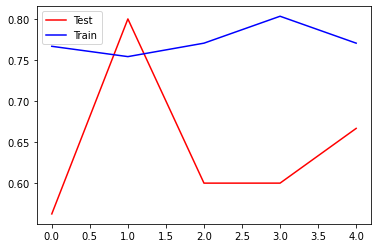

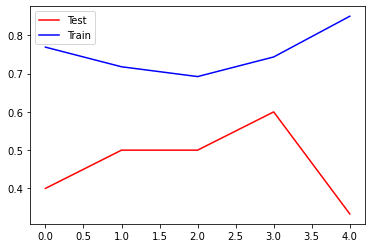

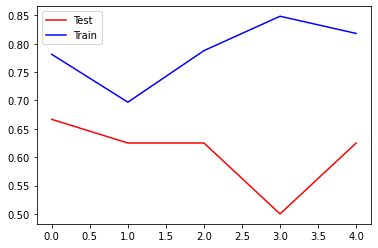

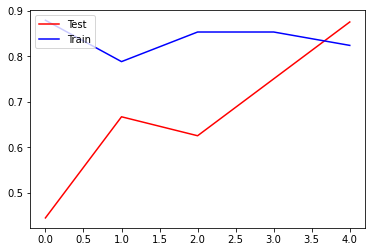

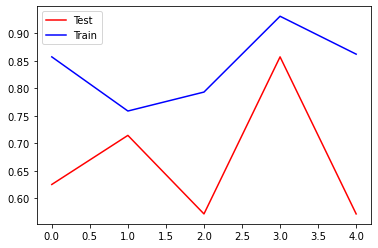

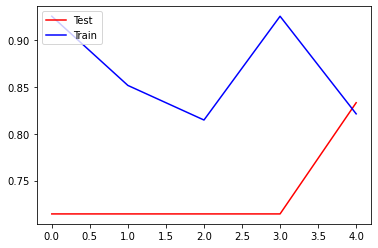

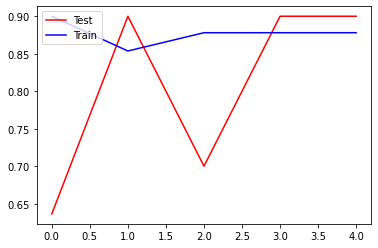

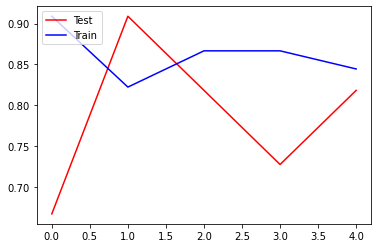

In [37]:
# Dataframes para coletas de métricas
Metricas = pd.DataFrame(columns = Colunas_metricas)

Execucao(dados=grupo_A, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_B, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_C, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_D, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_E, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_F, labels=labels, modelo="SVM", Metricas=Metricas)
# Execucao(dados=grupo_G, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_Expecial, labels=labels, modelo="SVM", Metricas=Metricas)
Execucao(dados=grupo_Expecial_2, labels=labels, modelo="SVM", Metricas=Metricas)

# Salvando resultados para arquivo
Metricas.to_csv(caminho_salvamentos + '\\' + "metricas_SVM_Grupos_Geral" + '.csv', index=False, na_rep='NaN')

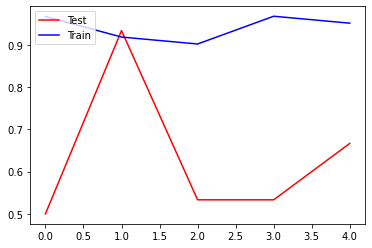

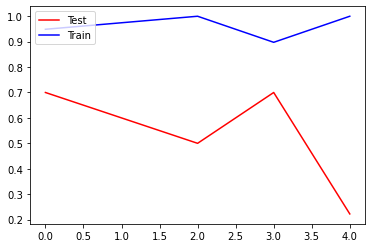

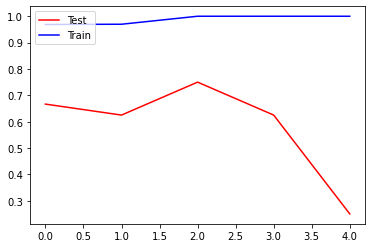

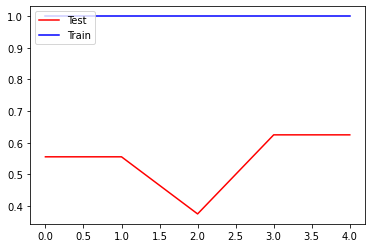

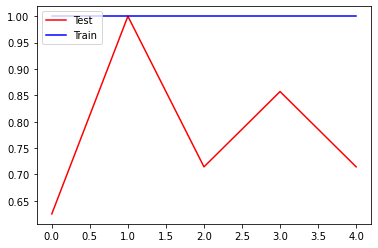

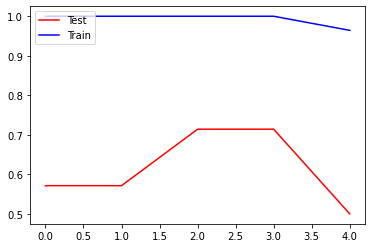

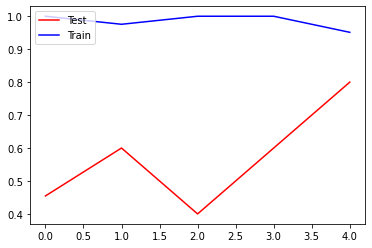

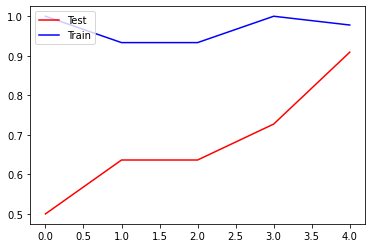

In [38]:
# Dataframes para coletas de métricas
Metricas = pd.DataFrame(columns = Colunas_metricas)

Execucao(dados=grupo_A, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_B, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_C, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_D, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_E, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_F, labels=labels, modelo="AD", Metricas=Metricas)
# Execucao(dados=grupo_G, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_Expecial, labels=labels, modelo="AD", Metricas=Metricas)
Execucao(dados=grupo_Expecial_2, labels=labels, modelo="AD", Metricas=Metricas)

# Salvando resultados para arquivo
Metricas.to_csv(caminho_salvamentos + '\\' + "metricas_AD_Grupos_Geral" + '.csv', index=False, na_rep='NaN')

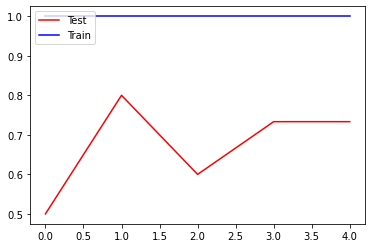

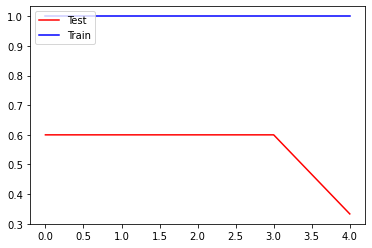

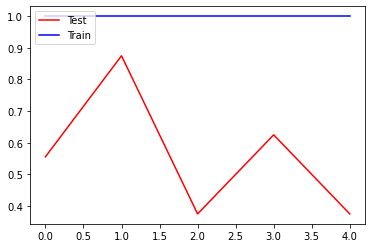

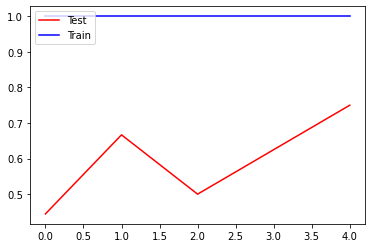

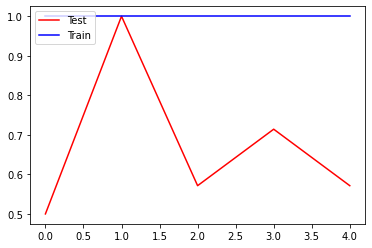

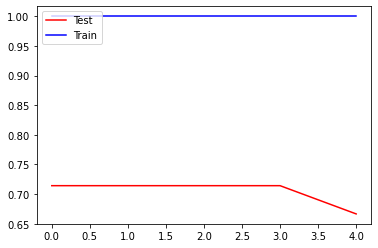

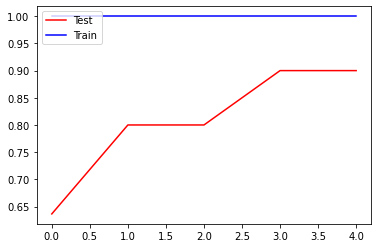

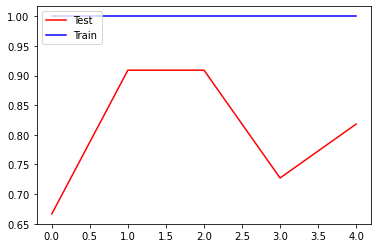

In [39]:
# Dataframes para coletas de métricas
Metricas = pd.DataFrame(columns = Colunas_metricas)

Execucao(dados=grupo_A, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_B, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_C, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_D, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_E, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_F, labels=labels, modelo="KNN", Metricas=Metricas)
# Execucao(dados=grupo_G, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_Expecial, labels=labels, modelo="KNN", Metricas=Metricas)
Execucao(dados=grupo_Expecial_2, labels=labels, modelo="KNN", Metricas=Metricas)

# Salvando resultados para arquivo
Metricas.to_csv(caminho_salvamentos + '\\' + "metricas_KNN_Grupos_Geral" + '.csv', index=False, na_rep='NaN')

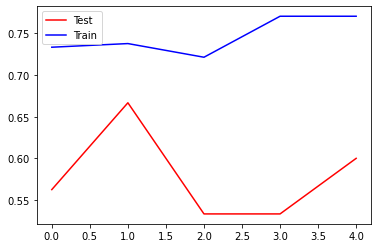

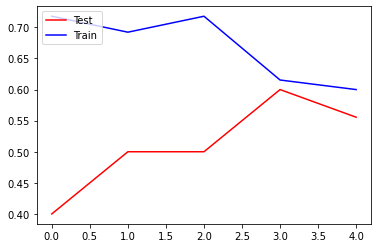

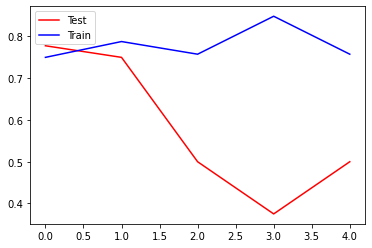

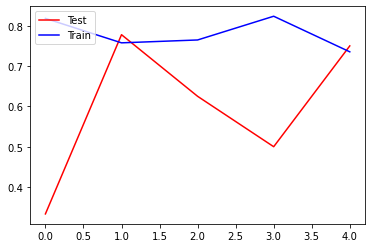

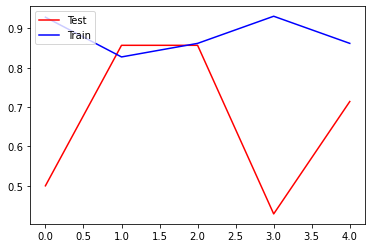

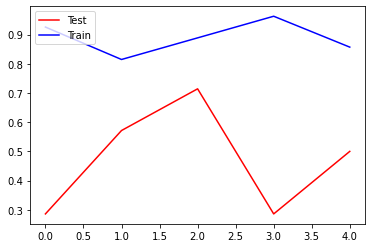

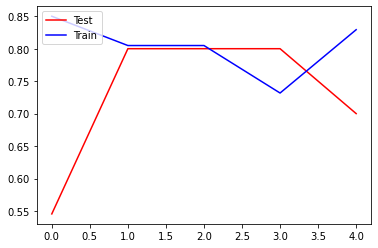

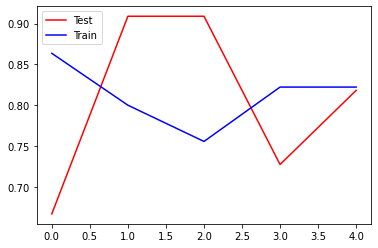

In [40]:
# Dataframes para coletas de métricas
Metricas = pd.DataFrame(columns = Colunas_metricas)

Execucao(dados=grupo_A, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_B, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_C, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_D, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_E, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_F, labels=labels, modelo="RL", Metricas=Metricas)
# Execucao(dados=grupo_G, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_Expecial, labels=labels, modelo="RL", Metricas=Metricas)
Execucao(dados=grupo_Expecial_2, labels=labels, modelo="RL", Metricas=Metricas)

# Salvando resultados para arquivo
Metricas.to_csv(caminho_salvamentos + '\\' + "metricas_RL_Grupos_Geral" + '.csv', index=False, na_rep='NaN')